In [1]:
import gzip

import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm.notebook import tqdm

In [2]:
# http://yann.lecun.com/exdb/mnist/

In [3]:
imgs = requests.get("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")
labels = requests.get("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")

In [4]:
buf = gzip.decompress(imgs.content)

In [5]:
prefix_size = int(32 / 8) * 4
np.frombuffer(buf[0:prefix_size], dtype=np.int32) # ???

array([  50855936, 1625948160,  469762048,  469762048], dtype=int32)

In [6]:
img_pixels = np.frombuffer(buf[prefix_size:], dtype=np.uint8).reshape(60_000, -1)

In [7]:
img_labels = np.frombuffer(gzip.decompress(labels.content)[8:], dtype=np.uint8)

In [8]:
K = np.unique(img_labels).shape[0]

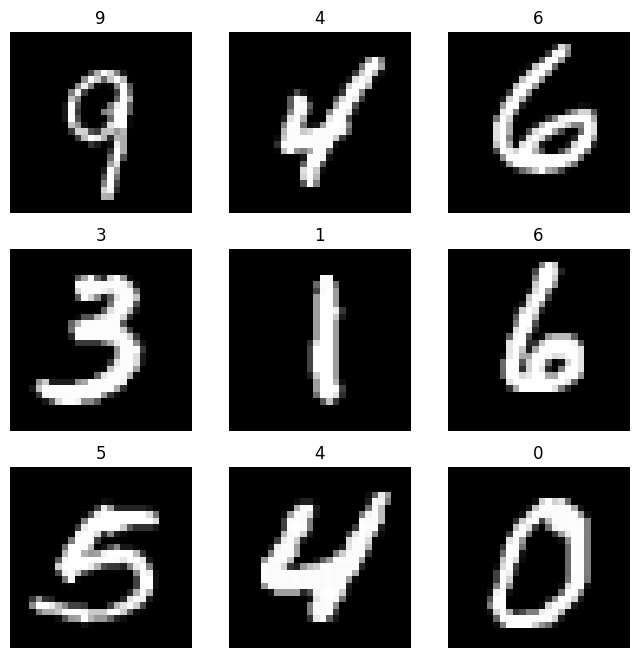

In [9]:
rng = np.random.RandomState(742)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
idx = rng.randint(0, img_labels.shape[0], size=9)
for i in range(9):
    axes[i].imshow(img_pixels[idx[i], :].reshape(28, 28), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(str(int(img_labels[idx[i]])), color="black", fontsize=12)
plt.show()

In [10]:
def relu(x):
    return np.where(x > 0, x, 0)

In [11]:
def forward(X, W, b):
    inner1 = relu(np.matmul(X, W[0]) + b[0])
    return softmax(inner1, W[1]), inner1

In [12]:
def softmax(X_in, weights):
    mul = np.matmul(X_in, weights)
    s = np.exp(np.where(mul < 2, mul, 2))
    return s / np.sum(s, axis=1).reshape(-1, 1)

In [13]:
def loss(y_pred, y_true):
    y_true_one_hot_vec = y_true[:, np.newaxis] == np.arange(K)
    loss_sample = (np.log(np.where(y_pred > 0, y_pred, 1e-4)) * y_true_one_hot_vec).sum(
        axis=1
    )
    return -np.mean(loss_sample), y_true_one_hot_vec

In [14]:
def backprop(W, b, X, y, alpha):

    out, inner1 = forward(X, W, b)
    _, y_one_hot = loss(out, y)
    delta2 = out - y_one_hot
    grad_W1 = np.matmul(inner1.T, delta2)
    delta1 = np.matmul(delta2, W[1].T) * (inner1 > 0)
    grad_W0 = np.matmul(X.T, delta1)
    N = X.shape[0]
    dW = [grad_W0 / N + alpha * W[0], grad_W1 / N + alpha * W[1]]
    db = [np.mean(delta1, axis=0)]
    return dW, db

In [15]:
alpha = 1e-6
num_iter = 1000
n_H = 256
n = img_pixels.shape[1]

rng = np.random.RandomState(742)
W = [1e-1 * rng.rand(n, n_H), 1e-1 * rng.rand(n_H, K)]
b = [rng.rand(n_H)]

train_inds = rng.choice(range(img_pixels.shape[0]), 50_000, replace=False)

X_train = img_pixels[train_inds, :].astype(np.float64)
y_train = img_labels[train_inds].astype(np.float64)


for i in tqdm(range(num_iter)):
    dW, db = backprop(W, b, X_train, y_train, alpha)
    W[0] -= dW[0]
    W[1] -= dW[1]
    b[0] -= db[0]

    if i % 50 == 0:
        y_pred, _ = forward(X_train, W, b)
        ce, _ = loss(y_pred, y_train)
        acc = np.mean(np.argmax(y_pred, axis=1) == y_train)
        print(
            f"train loss at {i + 1}: {round(ce, 3)} train accuracy: {round(acc * 100, 2)}%"
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

train loss at 1: 5.452 train accuracy: 9.85%
train loss at 51: 2.303 train accuracy: 9.85%
train loss at 101: 2.302 train accuracy: 9.86%
train loss at 151: 2.302 train accuracy: 9.86%
train loss at 201: 2.302 train accuracy: 9.86%
train loss at 251: 2.302 train accuracy: 9.86%
train loss at 301: 2.302 train accuracy: 9.86%
train loss at 351: 2.302 train accuracy: 9.86%
train loss at 401: 2.302 train accuracy: 9.86%
train loss at 451: 2.302 train accuracy: 9.86%
train loss at 501: 2.302 train accuracy: 9.86%
train loss at 551: 2.302 train accuracy: 9.86%
train loss at 601: 2.302 train accuracy: 9.86%
train loss at 651: 2.302 train accuracy: 9.86%
train loss at 701: 2.302 train accuracy: 9.86%
train loss at 751: 2.302 train accuracy: 9.86%
train loss at 801: 2.302 train accuracy: 9.86%
train loss at 851: 2.302 train accuracy: 9.86%
train loss at 901: 2.302 train accuracy: 9.86%
train loss at 951: 2.302 train accuracy: 9.86%


In [16]:
eta = 5e-1
gamma = 0.99
eps = 1e-3

rng = np.random.RandomState(742)
W = [1e-1 * rng.rand(n, n_H), 1e-1 * rng.rand(n_H, K)]
b = [rng.rand(n_H)]

gW0 = gW1 = gb0 = 1

for i in tqdm(range(num_iter)):
    dW, db = backprop(W, b, X_train, y_train, alpha)
    gW0 = gamma * gW0 + (1 - gamma) * np.sum(dW[0] ** 2)
    etaW0 = eta / np.sqrt(gW0 + eps)
    W[0] -= dW[0]  * etaW0

    gW1 = gamma * gW1 + (1 - gamma) * np.sum(dW[1] ** 2)
    etaW1 = eta / np.sqrt(gW1 + eps)
    W[1] -= dW[1] * etaW1

    gb0 = gamma * gb0 + (1 - gamma) * np.sum(db[0] ** 2)
    etab0 = eta / np.sqrt(gb0 + eps)
    b[0] -= db[0] * etab0 

    if i % 50 == 0:
        y_pred, _ = forward(X_train, W, b)
        ce, _ = loss(y_pred, y_train)
        acc = np.mean(np.argmax(y_pred, axis=1) == y_train)
        print(
            f"train loss at {i + 1}: {round(ce, 3)} train accuracy: {round(acc * 100, 2)}%"
        )
        gW0 = gW1 = gb0 = 1

  0%|          | 0/1000 [00:00<?, ?it/s]

train loss at 1: 12.83 train accuracy: 9.85%
train loss at 51: 1.876 train accuracy: 27.19%
train loss at 101: 1.588 train accuracy: 30.91%
train loss at 151: 1.54 train accuracy: 31.81%
train loss at 201: 1.552 train accuracy: 32.26%
train loss at 251: 1.501 train accuracy: 32.57%
train loss at 301: 1.533 train accuracy: 32.84%
train loss at 351: 1.497 train accuracy: 33.03%
train loss at 401: 1.5 train accuracy: 33.2%
train loss at 451: 1.491 train accuracy: 33.31%
train loss at 501: 1.477 train accuracy: 33.45%
train loss at 551: 1.474 train accuracy: 33.57%
train loss at 601: 1.472 train accuracy: 33.66%
train loss at 651: 1.47 train accuracy: 33.73%
train loss at 701: 1.468 train accuracy: 33.82%
train loss at 751: 1.466 train accuracy: 33.89%
train loss at 801: 1.465 train accuracy: 33.94%
train loss at 851: 1.463 train accuracy: 33.99%
train loss at 901: 1.462 train accuracy: 34.03%
train loss at 951: 1.461 train accuracy: 34.05%
